<a href="https://colab.research.google.com/github/himani5991/coursera--test/blob/master/Neural_network_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

from tensorflow import keras
from tensorflow.python.keras.layers import Dense

# Introduction
In a regression problem, we aim to predict some values based on
available information. For example, we want to estimate an expected
total discounted profit given current inventory level in the homework
inventory problem. Regression usually involves independent variables
(or features) $x$, dependent variables (or outputs) $y$, and unknown
parameters $\theta$ that we want to "learn". A regression model
relates dependent variables $y$ to features $x$ via a function
specified by parameters $\theta$:
\begin{align*}
y = f_\theta(x).
\end{align*}


In this note we show how to fit regression data through a neural network model in Python. 
Generally, we handle a regression problem through following steps:



1.   Generating dataset;
2.   Building a model;
3.  Preprocessing data;
4. Learning parameters;
5. Evaluating the model.

Note that that steps 2-5 are general for any regression problem with the neural network model.   

# Generating dataset

First, we need to get data. We will have three independent variables $x = [x_1, x_2, x_3]$ and one depended variable $y$.

We generate $N$ data points of the form $$\Big(X^i = [X_1^i, X_2^i, X_3^i], Y^i\Big)_{i=1}^N,$$ where $X^i$ have been randomly generated and
\begin{align*}Y^i = \frac{1}{3}\left(X_1^i+2X_2^i+\sin(X_3^i)\right) -5,\quad \quad \text{for }i=1,...,N.\end{align*}



We use the following  Python function to get dataset with $N$ data points:

In [ ]:
def CreateDataset(N):
    # dataset is regenerated based on 3 features x = [x1, x2, x3] and 
    # one output y = [x1 + 2*x2 + sim(x3)]/3 -5
    lin = np.arange(N)
    x1 = lin / 10. + np.random.uniform(-2, 2, N)
    x2 = lin / 30. + np.random.uniform(-4, 4, N)
    x3 = lin / 50. + np.random.uniform(-3, 3, N)
    y = (x1 + 2*x2 + np.sin(x3))/3. - 5.  # y = [x1 + 2*x2 + sim(x3)]/3 -5

    return np.vstack([x1, x2, x3]).T, y[:, np.newaxis]

In [ ]:
N = 200
x, y = CreateDataset(N)

print(np.shape(y))

Using dataset  $(X, Y)$ our goal will be to recover the relationship between features $x$ and output $y$ via a neural network $y=f_\theta(x)$.

##### Example of the training data:
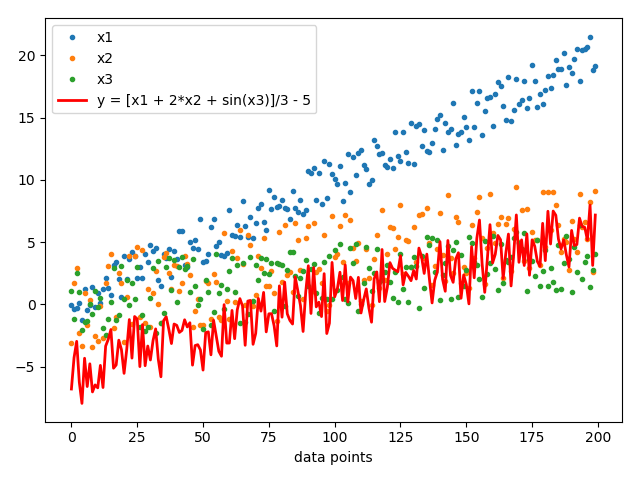

# Building a model

We choose a neural network as the model for function $f_\theta$. Building the neural network requires configuring its architecture, then compiling the model. The following discussion is intended to be an illustration of building a neural network. It is hoped that through this project, students are motivated to take a
full course on this subject.

The basic building block of a neural network is the layer.  A neural network model consists of an input layer, several hidden layers, and an output layer. These hidden layers allow one to extract more complicated representations from the data at the cost of increasing number of parameters that have to be learned. Our network will consist of a sequence of two hidden `tf.keras.layers.Dense' layers, meaning neural layers are densely connected (or fully connected).

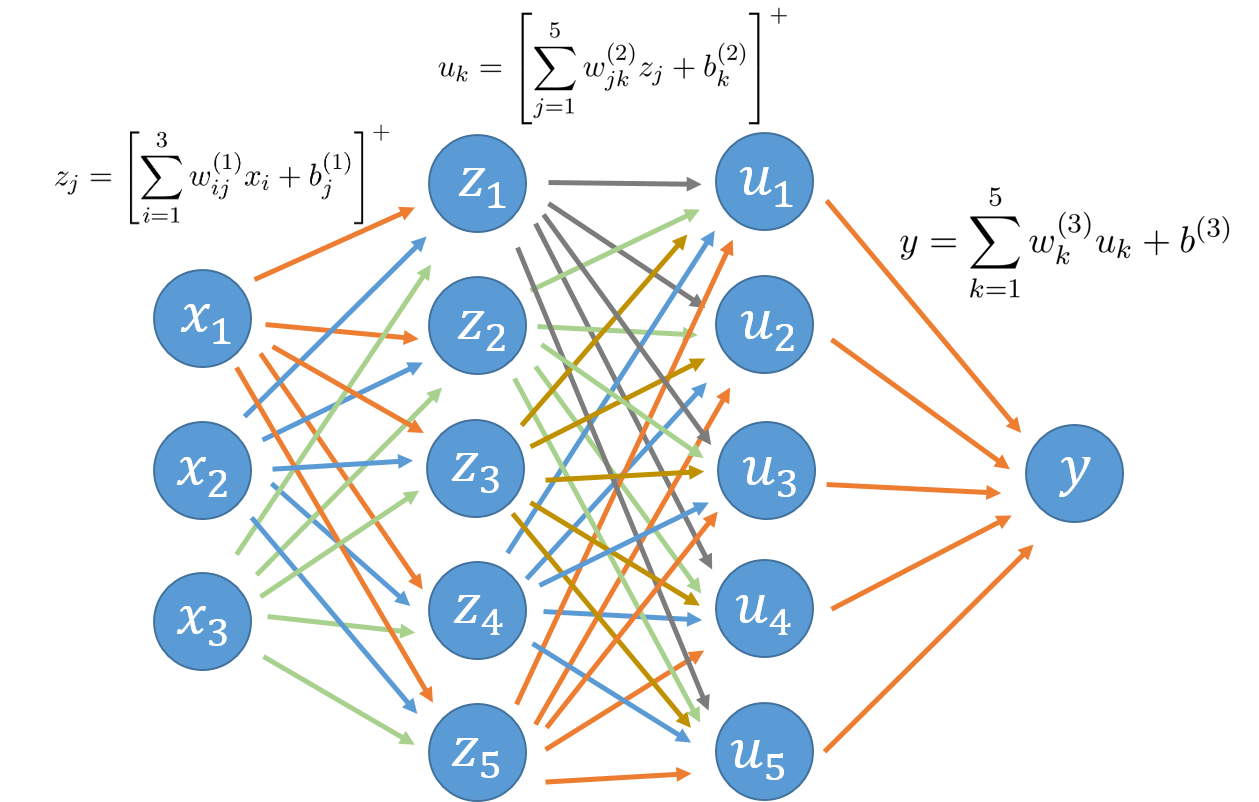

The nodes in the  first hidden lay are labeled as $Z_1$ through $Z_5$.
The nodes in the  second hidden lay are labeled as $U_1$ through $U_5$.
The number of nodes in a layer is known as the *width* of the layer.
The hidden layers often do not have the same width.

Each node receives input from nodes of a preceding layer. Thus each node in the
first hidden layer receives inputs from all nodes in the input layer, each node
in the second hidden layer receives inputs from all nodes in the first hidden layer, each (the) node in the output layer receives inputs from all nodes in the second hidden layer. Therefore, each node in a layer (excluding the input layer)  and each input node in the preceding layer forms a connection, on which
an associated weight (unknown parameter) is assigned. For example, $w^{(2)}_{jk}$
is the weight for connection from node $k$ in hidden layer 2 to the input node
$j$ in hidden layer $1$.
Each  node in a hidden layer applies the rectifier (`relu') activation function $[x]^+ = \max(0, x)$ to the weighted sum of its inputs and a bias vector -- another unknown parameter.
For example, the output of the $j$th node in the first hidden layer of our neural network model is:
\begin{align*}
z_j = \left[\sum\limits_{i=1}^3 w_{ij}^{(1)}x_i + b_{j}^{(1)}\right]^+,\quad\quad j=1, ..., 5. 
\end{align*}
 
The output of the $k$th node in the second hidden layer of the neural network model is equal to:
\begin{align*}
u_k = \left[\sum\limits_{j=1}^{5} w_{jk}^{(2)}z_j + b_{k}^{(2)}\right]^+,\quad\quad k=1, ..., 5. 
\end{align*}

In the last output layer a simple linear activation function is applied:
\begin{align*}
y = \sum\limits_{k=1}^{5} w_{k}^{(3)}u_k + b^{(3)}.
\end{align*}




Let us summarize all parameters that have to be learned:


*   In the first hidden layer we have 20 parameters : $w^{(1)} = \Big(w_{ij}^{(1)}\Big)_{i=1, j=1}^{3\times 5} $ and $b^{(1)} = \Big(b_j^{(1)}\Big)_{j=1}^{5}$.
*   In the second hidden layer -- 30 parameters: $w^{(2)} = \Big(w_{jk}^{(2)}\Big)_{j=1, k=1}^{5\times 5} $ and $b^{(2)} =\Big (b_k^{(2)}\Big)_{k=1}^{5}$.
* In the output layer -- 6 parameters: $w^{(3)} = \Big(w_k^{(3)}\Big)_{k=1}^{5} $ and $b^{(3)} \in \mathbb{R}.$


As we see the neural network model $f_\theta$ we have chosen has a
complicated structure and depends on 56 parameters
$\theta = \left[w^{(1)}, w^{(2)}, w^{(3)}, b^{(1)} , b^{(2)} ,
  b^{(3)}\right ]$.  In general, the number of hidden layers and the
width of each layers are hyper-parameters that need to be decided by
experiments.



After we have specified the architecture of the model, we need to compile it.  We are required to set:
* loss function,  the measure of how accurate the model is during training. In this example we want to minimize mean squared error: $\min\limits_{\theta}\frac{1}{N}\sum \limits_{i=1}^N (Y^i - f_\theta(X^i))^2$
* optimizer, the learning algorithm to find an $\theta$ in the previous optimization problem. 


The following Python code is responsible for building the model:

In [ ]:
class MyNeuralNetwork:
    def __init__(self, input_dimension):
        # define the keras model
        self.model = keras.Sequential()
        self.model.add(Dense(5, input_dim=input_dimension, 
        			activation='relu')) # 1st hidden layer
        self.model.add(Dense(5, activation='relu')) # 2nd hidden layer
        self.model.add(Dense(1, activation='linear')) # output layer
        # compile the keras model
        self.model.compile(loss='mean_squared_error', optimizer='adam')

# Preprocessing data

We will use $80\%$ of our dataset for learning (training). The rest data is a test set, which is not used for training. The test set allows one to check that the model has been learned successfully and we can expect the model to predict the output with high accuracy for inputs that have never been seen (not in the training set).

The following code is an example how one can divide available dataset into training and test sets.

In [ ]:
# divide data on training set and test set; 
# here  80% of data is used for training and 20% for testing
idx_train = np.random.choice(np.arange(len(x)), int(N * 0.8), replace=False)  # indexes included in training set
idx_test = np.ones((N,), bool)
idx_test[idx_train] = False  # indexes included in the test set
x_train = x[idx_train]
x_test = x[idx_test]
y_train = y[idx_train]
y_test = y[idx_test]

The numerical range of data can be wide and it is good practice to
normalize data. Although the optimization algorithms to find $\theta$
might still converge without data normalization, without such a normalization may
make the training more difficult.

The following Python class is created to compute means and variances of each feature and output:

In [ ]:
class Scaler:
    # save mean and variance of x, y sets
    def __init__(self, x, y):
        self.x_mean = np.mean(x, axis=0)
        self.y_mean = np.mean(y)
        self.x_std = np.std(x, axis=0)
        self.y_std = np.std(y)


    def get_x(self):
        # return saved mean and variance of x
        return self.x_std, self.x_mean

    def get_y(self):
        # return saved mean and variance of y
        return self.y_std, self.y_mean

Here is an example how this Python class is used to normalize data:

In [ ]:
normalizer = Scaler(x=x_train, y=y_train)
std_x, mean_x = normalizer.get_x()
x_train_norm = (x_train - mean_x) / std_x
x_test_norm = (x_test - mean_x) / std_x
std_y, mean_y = normalizer.get_y()
y_train_norm = (y_train - mean_y) / std_y

# Learning parameters

To start training, we call the `model.fit' method in the Python code. The parameters will be learned based on the normalized data (x\_train\_norm, y\_train\_norm).

In [ ]:
neural_network = MyNeuralNetwork(input_dimension=3)
neural_network.model.fit(x_train_norm, y_train_norm, epochs=100, batch_size=8)

Usually the dataset is large and it can be computationally expensive to pass all the data to the optimization algorithm at once. To overcome this issue we need to divide the data into smaller pieces (batches).  Before the beginning of a new epoch the entire dataset is randomly reshuffled and divided into batches, where a batch size specified by `batch\_size' in the code above. Then each batch is passed to the learning algorithm and the parameters of the neural networks are updated at the end of every such step. Therefore, after one epoch an entire dataset is passed through the neural network, but only once. In practice, many epochs are required to optimize the model. We use 100 epochs in the example.

# Evaluating  the model

Now it is time to use the test set to see how well our model can predict the output. Since the model has been trained on normalized data, we have to pass normalized data into `neural\_network.model.predict' method and scale the output of the  neural network back to the original range.



In [ ]:
y_from_nn_norm = neural_network.model.predict(x_test_norm)  # predict values for x_test states
y_from_nn = y_from_nn_norm * std_y + mean_y  # transform the results into original scaling

We compute the mean squared error between true values of the output 'y\_test' from the test set and values  obtained from the neural network 'y\_from\_nn':

In [ ]:
mse_loss = keras.losses.MeanSquaredError()
mse = mse_loss(y_test, y_from_nn).numpy()
print('Mean squared error: ', mse)

To visualize the accuracy of the trained neural network, we plot the true 'y_test' against the
'y_test_pred'

In [ ]:
t = np.array(range(len(y_test)))
plt.plot(t, y_test, "-b", label="True values")
plt.plot(t, y_from_nn, "-r", label="Predicted values")
plt.legend(loc="upper left")
plt.show()